In [1]:
import numpy as np
import matplotlib.pyplot as plt
from vespainv.model import VespaModel, Prior, VespaModel3c, Prior3c
from vespainv.waveformBuilder import create_U_from_model, create_U_from_model_3c, create_U_from_model_3c_freqdomain

In [2]:
# Parameter setup
modname = "model3"
Nphase = 3
is3c = True

# Parameter setup: stf
f0 = 0.2
dt = 0.05

# Parameter setup: time vector
tmax = 120

# Parameter setup: array
base_dist = 35.0
base_baz = 70.0
Ntrace = 50

# synDir = os.path.join("./SynData/", modname)
# os.makedirs(synDir, exist_ok=True)

# Create stf
stf_time_0 = np.arange(-4 / f0, 4 / f0 + dt, dt)
stf_0 = np.exp(-stf_time_0 ** 2 / (2 * (1 / (2 * np.pi * f0)) ** 2))
stf_time = stf_time_0[:-1]
stf = np.diff(stf_0) / np.diff(stf_time_0)
stf = stf / np.max(np.abs(stf))

# Pack and save stf
stf_array = np.column_stack([stf_time, stf])
# np.savetxt(os.path.join(synDir, "stf_syn.csv"), stf_array, delimiter=",", header="time,stf", comments="")

# Generate station metadata and save
time = np.arange(0, tmax, dt)
# np.random.seed(0)
dists = base_dist + np.random.uniform(-2.0, 2.0, Ntrace)
bazs = base_baz + np.random.uniform(-2.0, 2.0, Ntrace)
station_metadata = np.column_stack((dists, bazs))

# np.savetxt(os.path.join(synDir, "station_metadata.csv"), station_metadata, delimiter=",", header="distance,baz", comments="")

# Define prior and model, and save
if is3c:
    prior = Prior3c(refLat = 0., refLon = 0.,refBaz=base_baz, timeRange=(time[0],time[-1]), ampRange=(0.5, 1), slwRange=(0,0.1))
    model = VespaModel3c.create_random(Nphase=Nphase, Ntrace=Ntrace, time=time, prior=prior, arr=np.array([30, 60, 90]))
else:
    prior = Prior(refLat = 0., refLon = 0.,refBaz=base_baz, timeRange=(time[0],time[-1]), ampRange=(0.5, 1))
    model = VespaModel.create_random(Nphase=Nphase, Ntrace=Ntrace, time=time, prior=prior)

# Generate U, plot, and save
if is3c:
    U, _, _ = create_U_from_model_3c(model, prior, station_metadata, time, stf_time, stf)
    U2, _, _ = create_U_from_model_3c_freqdomain(model, prior, station_metadata, time, stf_time, stf)
else:
    U = create_U_from_model(model, prior, station_metadata, time, stf_time, stf)

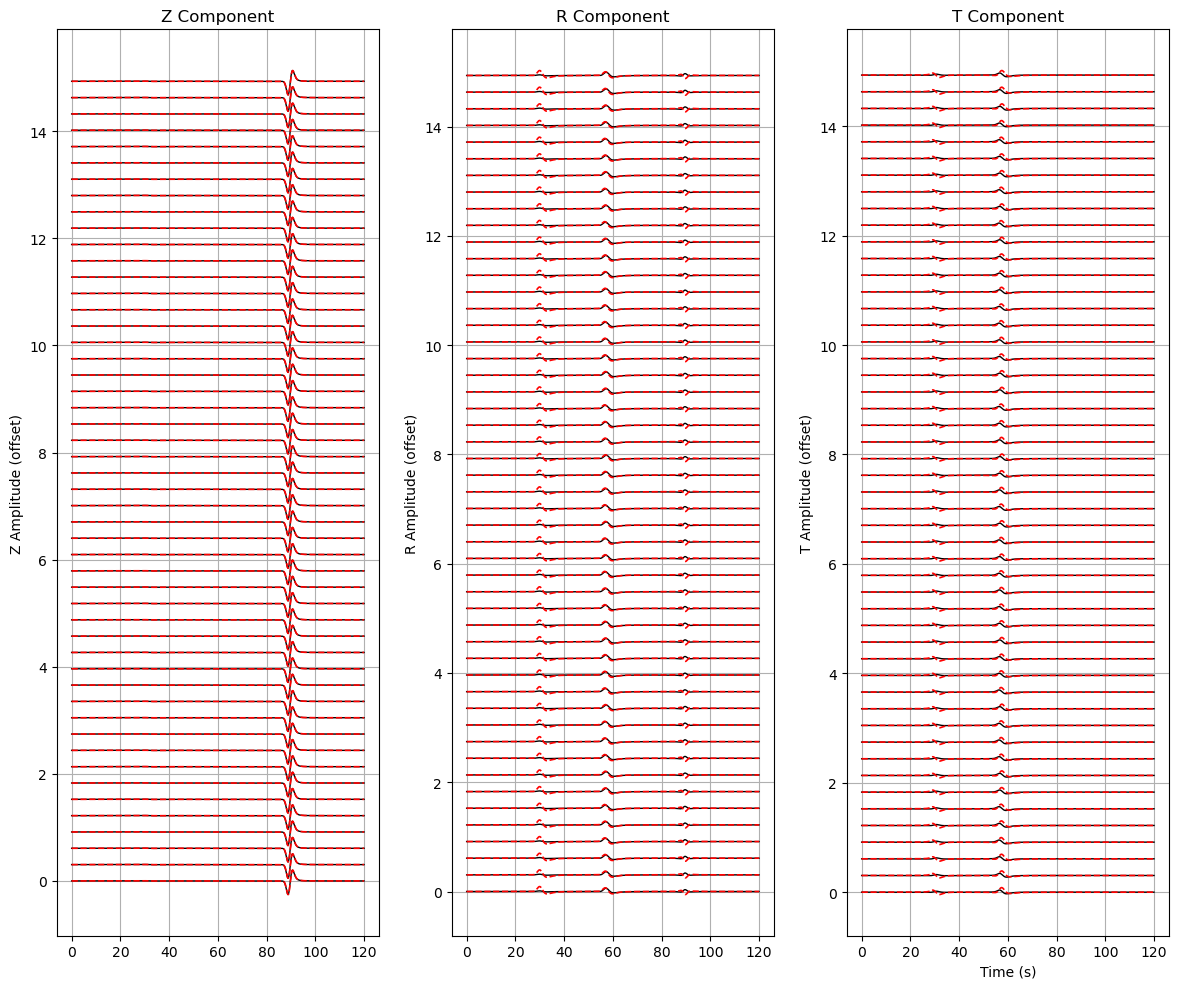

In [5]:
# Plot U
if is3c:
    components = ['Z', 'R', 'T']
    fig, axes = plt.subplots(1, 3, figsize=(12, 10), sharex=True)
    offset = 1.2 * np.max(np.abs(U))  # spacing between traces
    n_traces = U.shape[0]
    for i, ax in enumerate(axes):
        for j in range(n_traces):
            ax.plot(time, U[j, :, i] + j * offset, color='black', linewidth=1.0, label='Original' if j == 0 else "")
            ax.plot(time, U2[j, :, i] + j * offset, color='red', linestyle='--', linewidth=1.2, label='Modified' if j == 0 else "")

        ax.set_ylabel(f"{components[i]} Amplitude (offset)")
        ax.set_title(f"{components[i]} Component")
        ax.grid(True)
    axes[-1].set_xlabel("Time (s)")
    plt.tight_layout()
else:
    plt.figure(figsize=(10, 6))
    n_traces = U.shape[0]
    offset = 1.2 * np.max(np.abs(U))  # spacing between traces
    for i in range(n_traces):
        plt.plot(time, U[i, :] + i * offset, color="black")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (offset by trace index)")
    plt.title("Synthetic Seismograms")
    plt.grid(True)
    plt.tight_layout()

plt.show()